# Airline Passenger Satisfaction Analysis

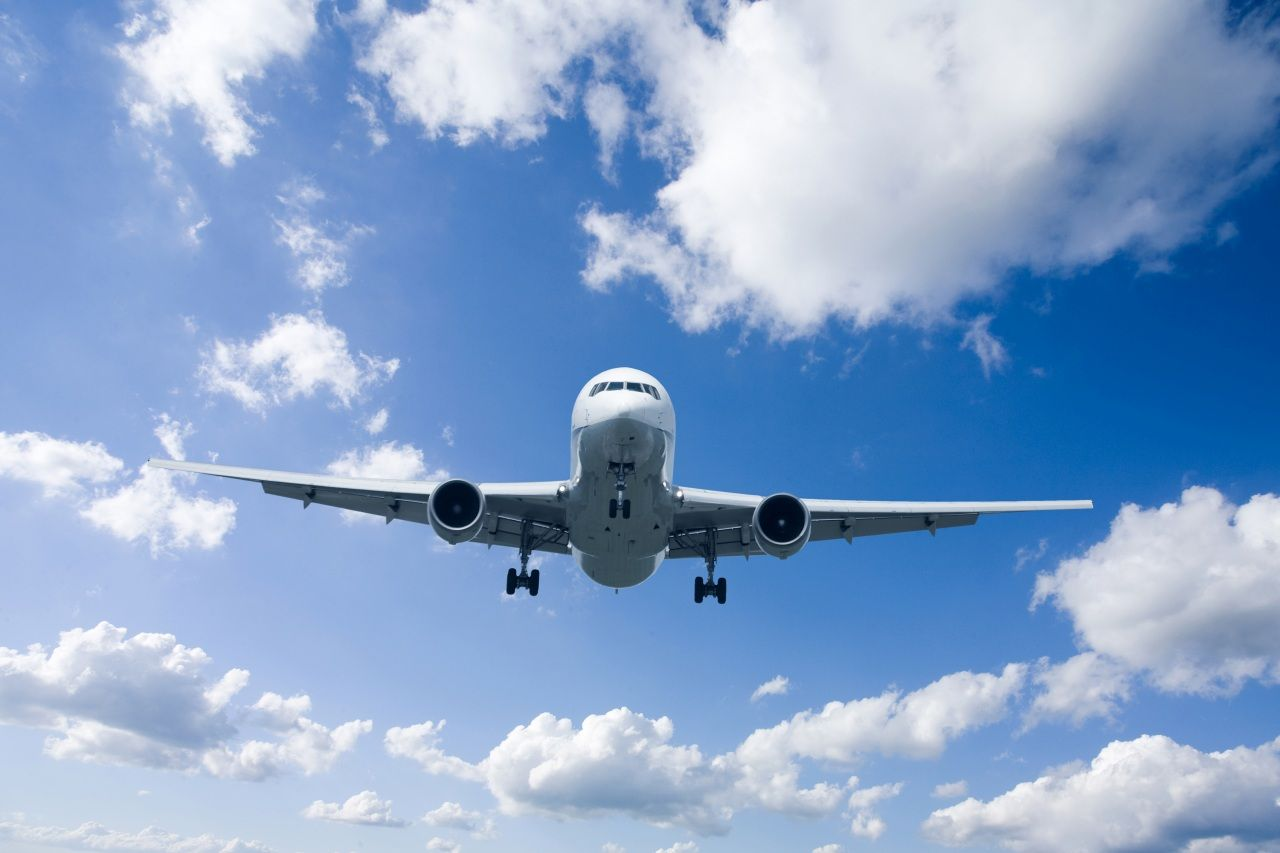

***

# Table of Contents

### 0 [Libraries](#section0)

### 1 [Data](#section1)

### 2 [Data Visualization](#section2)

### 3 [Data Wrangling](#section3)

### 4 [Feature Importance](#section4)
* 4.1 [Clustering Algorithm - K-Means](#section4.1)
* 4.2 [Visualization Algorithm - PCA](#section4.2)
* 4.3 [Classification Algorithms](#section4.3)
* 4.4 [Conclusions](#section4.4)

### 5 [Classification](#section5)
* 5.1 [Random Forest Classifier](#section5.1)
* 5.2 [Ada-Boost Classifier](#section5.2)
* 5.3 [MLP (Multi-Layer Perceptron)](#section5.3)
* 5.4 [Logistic Regression](#section5.4)
* 5.5 [Comparison](#section5.5)

### 6 [Regression](#section6)
* 6.1 [New Label](#section6.1)
* 6.2 [Method 1 - Drop Features](#section6.2)
* 6.3 [Method 2 - Don't Drop Features](#section6.3)
* 6.4 [Methods Comparison](#section6.4)

### 7 [Discussion and Conclusions](#section7)

***

# 0 Libraries <a class="anchor" id="section0"></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 3
from sklearn.preprocessing import LabelEncoder, StandardScaler

# 4
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from plotnine import *
from sklearn.decomposition import PCA

# 5
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

# 6
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor

# seed
RSEED = 10

# colors
cmap = 'Blues'

***

# 1 Data <a class="anchor" id="section1"></a>

The dataset contains an airline passenger satisfaction survey. In this project, we attempt to find the features that affect the satisfaction of the clients the most. In addition, we use different algorithms to predict that satisfaction.

**Content:**
- Gender: Gender of the passengers (Female, Male)
- Customer Type: The customer type (Loyal customer, disloyal customer)
- Age: The actual age of the passengers
- Type of Travel: Purpose of the flight of the passengers (Personal Travel, Business Travel)
- Class: Travel class in the plane of the passengers (Business, Eco, Eco Plus)
- Flight distance: The flight distance of this journey
- Inflight wifi service: Satisfaction level of the inflight wifi service (0:Not Applicable; 1-5)
- Departure/Arrival time convenient: Satisfaction level of departure/arrival time convenient
- Ease of Online booking: Satisfaction level of online booking
- Gate location: Satisfaction level of gate location
- Food and drink: Satisfaction level of Food and drink
- Online boarding: Satisfaction level of online boarding
- Seat comfort: Satisfaction level of seat comfort
- Inflight entertainment: Satisfaction level of inflight entertainment
- On-board service: Satisfaction level of on-board service
- Leg room service: Satisfaction level of leg room service
- Baggage handling: Satisfaction level of baggage handling
- Check-in service: Satisfaction level of check-in service
- Inflight service: Satisfaction level of inflight service
- Cleanliness: Satisfaction level of Cleanliness
- Departure Delay in Minutes: Minutes delayed when departure
- Arrival Delay in Minutes: Minutes delayed when Arrival
- Satisfaction: Airline satisfaction level (Satisfaction, neutral or dissatisfaction)

In [ ]:
train = pd.read_csv('../input/airline-passenger-satisfaction/train.csv')
test = pd.read_csv('../input/airline-passenger-satisfaction/test.csv')

In [ ]:
train.head()

In [ ]:
test.head()

The columns `Unnamed: 0` and `id` are irrelevant and thus will be dropped.

In [ ]:
train.drop(['Unnamed: 0', 'id'], axis=1, inplace=True)
test.drop(['Unnamed: 0', 'id'], axis=1, inplace=True)

***

# 2 Data Visualization <a class="anchor" id="section2"></a>

In [ ]:
sns.set_theme(style='whitegrid', palette=cmap)

In [ ]:
df = train.append(test)

### Target Variable - Satisfaction

It seems like the data is quite balanced, with slightly more neutral or dissatisfied costumers.

In [ ]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='satisfaction', data=df)
plt.title('Barplot of Satisfaction (Target)', fontsize=14)
plt.xlabel('Satisfaction (Target)', fontsize=13)
plt.ylabel('Count', fontsize=13)
plt.show()

### Categorical Variables

In [ ]:
# define categorical columns list
cat_cols = ['Gender', 'Customer Type', 'Type of Travel', 'Class']

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
axs = axs.ravel()

i=0
for col in cat_cols:
    
    # define location
    plt.subplot(2, 2, i+1)
    
    # create plot
    ax = plt.gca()
    axs[i] = sns.countplot(x = col, hue = 'satisfaction', data = df)
    
    # remove legend
    ax.legend('')
    
    i += 1

# add legend
axs[1].legend(loc='upper right', fontsize=16)

plt.tight_layout()
plt.show()

We see a few interesting points:
- Males and females have similar satisfaction rates.
- Disployal costumers are more dissatisfied compared to loyal costumers.
- Personal travel are more dissatisfied compared to buisness travel.
- Eco class are more dissatisfied compared to buisness class.

### Correlation

In [ ]:
# create labels for categorical columns
label = LabelEncoder()

labeled_df = df.copy()
for i in cat_cols:
    labeled_df[i] = label.fit_transform(labeled_df[i])

In [ ]:
plt.figure(figsize=(15, 12))
sns.heatmap(labeled_df.corr(), cmap=cmap)
plt.title('Heatmap of Train Dataset', fontsize=14)
plt.show()

In [ ]:
cor = df['Departure Delay in Minutes'].corr(df['Arrival Delay in Minutes'])

Most features don't seem to be very correlated, except for `Departure Delay in Minutes` and `Arrival Delay in Minutes` which have a correlation score of 0.96.

***

# 3 Data Wrangling <a class="anchor" id="section3"></a>

### Labels

In [ ]:
def transform_satisfaction(x):
    if x == 'satisfied':
        return 1
    elif x == 'neutral or dissatisfied':
        return 0
    else:
        return -1

In [ ]:
train['satisfaction'] = train['satisfaction'].apply(transform_satisfaction)
test['satisfaction'] = test['satisfaction'].apply(transform_satisfaction)

### Missing Values

In [ ]:
df.isnull().sum()

Earlier, we saw that the variable `Arrival Delay in Minutes` is highly correlated with the variable `Departure Delay in Minutes`, and we wish to drop one. As `Arrival Delay in Minutes` has many missing values, we've decided to drop it.

In [ ]:
train.drop('Arrival Delay in Minutes', axis=1, inplace=True)
test.drop('Arrival Delay in Minutes', axis=1, inplace=True)

### One-Hot Encoding

In [ ]:
dummy_train = pd.get_dummies(train, columns=cat_cols, drop_first=True)
dummy_test = pd.get_dummies(test, columns=cat_cols, drop_first=True)

In [ ]:
dummy_train.head()

In [ ]:
train_df = dummy_train.copy()
test_df = dummy_test.copy()

### Scaling

In [ ]:
train_cols = train_df[['Age', 'Flight Distance', 'Departure Delay in Minutes']]
test_cols = test_df[['Age', 'Flight Distance', 'Departure Delay in Minutes']]

In [ ]:
scaler = StandardScaler()
scaled_train = pd.DataFrame(scaler.fit_transform(train_cols), columns = train_cols.columns)
scaled_test = pd.DataFrame(scaler.fit_transform(test_cols), columns = test_cols.columns)

In [ ]:
scaled_train.head().style.set_properties(**{'text-align': 'center'}).set_table_styles([dict(selector='th', props=[('text-align', 'center')])])

In [ ]:
cols = ['Age', 'Flight Distance', 'Departure Delay in Minutes']

train_df[cols] = scaled_train
test_df[cols] = scaled_test

In [ ]:
train_df.head().style.set_properties(**{'text-align': 'center'}).set_table_styles([dict(selector='th', props=[('text-align', 'center')])])

***

# 4 Feature Importance <a class="anchor" id="section4"></a>

In this section, we attempt to find the features that affect the clients' satisfaction the most, using different methods.

## 4.1 Clustering Algorithm - K-Means <a class="anchor" id="section4.1"></a>

We use the K-Means clustering algorithm to identify clusters and find important features in each cluster.

First, we define th `elbow_met` function to find the optimal number of clusters $k$.

In [ ]:
def elbow_met(df):
    distortions = []
    K = range(1,10)
    for k in K:
        kmeanModel = KMeans(n_clusters=k, random_state=RSEED).fit(df)
        kmeanModel.fit(df)
        distortions.append(sum(np.min(cdist(df, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / df.shape[0])

    # Plot the elbow
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Within groups sum of squares')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

In [ ]:
elbow_met(train_df)

We select $k=3$ and fit the model.

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=RSEED)
kmeans.fit(train_df)

We define a function `get_melted_clusters` to assign the observations to the clusters created by K-Means.

In [ ]:
def get_melted_clusters(labels):
    result_df = dm.copy()
    
    result_df["cluster"] = labels
    melt_cluster = result_df.groupby("cluster").mean().reset_index().melt(id_vars="cluster")
    melt_cluster = melt_cluster["variable"].str.split("_" , expand=True).join(melt_cluster)
    melt_cluster = melt_cluster.rename({0 : "variable_base" , 1:"response"} , axis=1)
    melt_cluster["cluster"] = melt_cluster["cluster"].astype("category") 
    return melt_cluster

In the following plots, we present the different features and the percentage of observations that belong to every category, divided by cluster.

In [ ]:
dm = pd.get_dummies(train, columns=['satisfaction'])
mc = get_melted_clusters(kmeans.labels_)

(
    ggplot(mc[~mc["response"].isna()], aes(x="response", y="value", fill="cluster"))
    + geom_col(position="fill")
    + labs(x='Value', y='Percentage')
    + coord_flip()
    + facet_wrap("~ variable_base")
    + theme(figure_size=(5, 4))
    + scale_fill_manual(values=('#c6dbef', '#6baed6', '#08306b'))
)

In [ ]:
cols = ['Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort', 'Inflight entertainment', 'On-board service',
       'Leg room service', 'Baggage handling', 'Checkin service', 'Inflight service', 'Cleanliness']

dm = pd.get_dummies(train, columns=cols, drop_first=True)
mc = get_melted_clusters(kmeans.labels_)

(
    ggplot(mc[~mc["response"].isna()], aes(x="response", y="value", fill="cluster"))
    + geom_col(position="fill")
    + labs(x='Value', y='Percentage')
    + coord_flip()
    + facet_wrap("~ variable_base")
    + theme(figure_size=(12, 10), legend_position = (0.6, 0.2)) 
    + scale_fill_manual(values=('#c6dbef', '#6baed6', '#08306b'))
)

In [ ]:
dm = pd.get_dummies(train, columns=['Gender'])
mc = get_melted_clusters(kmeans.labels_)

(
    ggplot(mc[~mc["response"].isna()], aes(x="response", y="value", fill="cluster"))
    + geom_col(position="fill")
    + labs(x='Value', y='Percentage')
    + coord_flip()
    + facet_wrap("~ variable_base")
    + theme(figure_size=(5, 4))
    + scale_fill_manual(values=('#c6dbef', '#6baed6', '#08306b'))
)

In [ ]:
dm = pd.get_dummies(train, columns=['Customer Type'])
mc = get_melted_clusters(kmeans.labels_)

(
    ggplot(mc[~mc["response"].isna()], aes(x="response", y="value", fill="cluster"))
    + geom_col(position="fill")
    + labs(x='Value', y='Percentage')
    + coord_flip()
    + facet_wrap("~ variable_base")
    + theme(figure_size=(5, 4))
    + scale_fill_manual(values=('#c6dbef', '#6baed6', '#08306b'))
)

In [ ]:
dm = pd.get_dummies(train, columns=['Type of Travel'])
mc = get_melted_clusters(kmeans.labels_)

(
    ggplot(mc[~mc["response"].isna()], aes(x="response", y="value", fill="cluster"))
    + geom_col(position="fill")
    + labs(x='Value', y='Percentage')
    + coord_flip()
    + facet_wrap("~ variable_base")
    + theme(figure_size=(5, 4))
    + scale_fill_manual(values=('#c6dbef', '#6baed6', '#08306b'))
)

In [ ]:
dm = pd.get_dummies(train, columns=['Class'])
mc = get_melted_clusters(kmeans.labels_)

(
    ggplot(mc[~mc["response"].isna()], aes(x="response", y="value", fill="cluster"))
    + geom_col(position="fill")
    + labs(x='Value', y='Percentage')
    + coord_flip()
    + facet_wrap("~ variable_base")
    + theme(figure_size=(5, 4))
    + scale_fill_manual(values=('#c6dbef', '#6baed6', '#08306b'))
)

### Conclusions

**Cluster 0:**
- Quite neutral satisfaction (a bit more satisfied).
- Features that had high ratings:
    - Cleanliness
    - Food and drink
    - Inflight entertainment
- Features that had low ratings: 
    - Departure/Arrival time
    - Ease of Online booking
    - Gate location


**Cluster 1:**
- Not satisfied with their experience.
- Mostly disloyal costumers in Eco/Eco Plus class for personal travel.
- Features that had extremely low ratings: 
    - Cleanliness
    - Food and drink
    - Inflight entertainment
    - Inflight service
    - Seat comfort


**Cluster 2:**
- Mostly satisfied with their experience.
- Mostly loyal costumers in buisness class for buisness travel.
- Features that had extremely high ratings:
    - Departure/Arrival time
    - Ease of Online booking
    - Gate location
    - Inflight wifi service

## 4.2 Visualization Algorithm - PCA <a class="anchor" id="section4.2"></a>

We use the PCA algorithm to find important features.

First, we fit and transform the data using PCA.

In [ ]:
pca = PCA(random_state=RSEED)
pca.fit(train_df)
pca_data = pca.transform(train_df)

Next, we create a scree plot to visualize the percentage of explained variance for each PC.

In [ ]:
per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

plt.figure(figsize=(16, 6))
plt.bar(x=range(1, len(per_var)+1), height=per_var, tick_label=labels, color='#9ecae1')
plt.ylabel('Percentage of Explained Variance', fontsize=13)
plt.xlabel('Principal Component', fontsize=13)
plt.title('Scree Plot', fontsize=14)
plt.show()

In the following table we see the 10 most important features for the first principal component.

In [ ]:
loading_scores = pd.Series(pca.components_[0], index=train_df.columns)
sorted_loading_scores = loading_scores.abs().sort_values(ascending=False)
top_10_features = sorted_loading_scores[0:10].index.values
top_features = pd.DataFrame(loading_scores[top_10_features], columns=['Score'])
top_features.style.set_properties(**{'text-align': 'center'}).set_table_styles([dict(selector='th', props=[('text-align', 'left')])])

## 4.3 Classification Algorithms <a class="anchor" id="section4.3"></a>

We fit a Random Forest and and Ada-Boost model and find the most important features.

In [ ]:
X_train = train_df.drop(['satisfaction'], axis=1)
y_train = train_df['satisfaction']
X_test = test_df.drop(['satisfaction'], axis=1)
y_test = test_df['satisfaction']

### Random Forest Classifier

In [ ]:
rf = RandomForestClassifier(random_state=RSEED)

parameters_grid = {
    'max_depth': [5, 15],
    'min_samples_leaf': [2, 8],
    'n_estimators': [50, 100],
    'max_features': [5, 10]
}

# define grid search
grid_search = GridSearchCV(estimator=rf, param_grid=parameters_grid, cv=10, n_jobs=-1)

# fit estimator
grid_search.fit(X_train, y_train)

# get feature importance
imp = pd.DataFrame(grid_search.best_estimator_.fit(X_train, y_train).feature_importances_, 
                   index=X_train.columns, columns=['Importance']).sort_values('Importance')

plt.figure(figsize=(8, 6))
plt.barh(range(0, len(imp)), imp['Importance'], color='#9ecae1')
plt.grid(axis='x', alpha=0.5, color='lightgrey')
plt.yticks(range(0, len(imp)), imp.index)
plt.title('Feature Importance', fontsize=14)
plt.show()

According to the Random Forest algorithm, the most important features are:
- Online boarding
- Inflight wifi service
- Type of Travel - Personal Travel 

### Ada-Boost Classifier

In [ ]:
ab = AdaBoostClassifier(random_state=RSEED)

parameters_grid = {
    'n_estimators': [50, 100],
    'learning_rate': [0.001, 0.01, 0.1]
}

# define grid search
grid_search = GridSearchCV(estimator=ab, param_grid=parameters_grid, cv=10, n_jobs=-1)

# fit estimator
grid_search.fit(X_train, y_train)

# get feature importance
imp = pd.DataFrame(grid_search.best_estimator_.fit(X_train, y_train).feature_importances_, 
                   index=X_train.columns, columns=['Importance']).sort_values('Importance')

plt.figure(figsize=(8, 6))
plt.barh(range(0, len(imp)), imp['Importance'], color='#9ecae1')
plt.grid(axis='x', alpha=0.5, color='lightgrey')
plt.yticks(range(0, len(imp)), imp.index)
plt.title('Feature Importance', fontsize=14)
plt.show()

According to the Ada-Boost algorithm, the most important features are:
- Inflight wifi service
- Type of Travel - Personal Travel
- Online boarding 

The same features as the Random Forest, but in different order.

## 4.4 Conclusion <a class="anchor" id="section4.4"></a>

According to the first two methods, K-Means clustering and PCA, the most important features are:
- Cleanliness
- Food and drink
- Inflight entertainment

According to the classification algorithms, the most important features are:
- Online boarding
- Inflight wifi service
- Type of Travel - Personal Travel 

***

# 5 Classification <a class="anchor" id="section5"></a>

In this section, we apply several classification algorithms on the data. To compare the methods, we calculate the accuracy and F1 score.

**Accuracy**: refers to the ability to correctly predict both positive and negative obseravtions.

$$\text{Accuracy} = \frac{\text{True Positive} + \text{True Negative}}{\text{True Positive} + \text{True Negative} + \text{False Positive} + \text{False Negative}}$$

**F1 Score**: conveys the balance between the precision and the recall.

$$F_1 = 2\cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}$$

where precision and recall and defined by
$$\text{Precision} = \frac{\text{True Positive}}{\text{True Positive} + \text{False Positive}}~, \quad \text{Recall} = \frac{\text{True Positive}}{\text{True Positive} + \text{False Negative}}$$

We believe that these two measures are good evaluation metrics for our case because the data is balanced and we want both good precision and recall.

In [ ]:
X_train = train_df.drop(['satisfaction'], axis=1)
y_train = train_df['satisfaction']
X_test = test_df.drop(['satisfaction'], axis=1)
y_test = test_df['satisfaction']

We define three functions to avoid code repetition:

1. The `fit_predict` function, uses the input train data to fit a given model, and predicts the label for the test features. A parameters grid is also recieved as input and is used to for hyperparameter optimization.

In [ ]:
def fit_predict(X_train, X_test, y_train, model, parameters_grid):
    
    # define grid search
    grid_search = GridSearchCV(estimator=model, param_grid=parameters_grid, cv=10, n_jobs=-1)
    
    # fit estimator
    grid_search.fit(X_train, y_train)
    
    # get best estimator
    best = grid_search.best_estimator_
    
    # predict
    y_pred = best.predict(X_test)
    
    return y_pred, grid_search

2. The `get_class_metrics` function calculates the accuracy and F1 Score, given the test and predicted label, and creates a confusion matrix.

In [ ]:
def get_class_metrics(y_test, y_pred):
  
    # calculate accuracy and f1-score
    acc = round(accuracy_score(y_test, y_pred), 3)
    f1 = round(f1_score(y_test, y_pred), 3)
    scores = [acc, f1]
    
    # Get confusion matrix
    mat = confusion_matrix(y_test, y_pred)
    
    # create confusion matrix
    sns.heatmap(mat, annot=True, cmap=cmap, fmt='d')
    plt.xlabel('Predicted', fontsize=13)
    plt.ylabel('True', fontsize=13)
    plt.title('Confusion Matrix', fontsize=14)
    
    return scores, plt

3. The `display_df` method is used to create and display the dataframe for the accuracy and F1 scores.

In [ ]:
def display_df(scores, model):
    df = pd.DataFrame(scores).T
    df = df.rename(index={0: model}, columns={0: 'Accuracy', 1: 'F1 Score'})
    return(df)

## 5.1 Random Forest Classifier <a class="anchor" id="section5.1"></a>

In [ ]:
rf = RandomForestClassifier(random_state=RSEED)

parameters_grid = {
    'max_depth': [5, 15],
    'min_samples_leaf': [2, 8],
    'n_estimators': [50, 100],
    'max_features': [5, 10]
}

# get predictions
y_pred, grid_search = fit_predict(X_train, X_test, y_train, rf, parameters_grid)

# calculate metrics
scores, mat = get_class_metrics(y_test, y_pred)

In [ ]:
rfc_res = display_df(scores, 'Random Forest Classifier')
rfc_res

**Selected Parameters:**

In [ ]:
pd.DataFrame.from_dict(grid_search.best_params_, orient='index', columns=['Selected Value']).T

## 5.2 Ada-Boost Classifier

In [ ]:
ab = AdaBoostClassifier(random_state=RSEED)

parameters_grid = {
    'n_estimators': [50, 100],
    'learning_rate': [0.001, 0.01, 0.1]
}

# get predictions
y_pred, grid_search = fit_predict(X_train, X_test, y_train, ab, parameters_grid)

# calculate metrics
scores, mat = get_class_metrics(y_test, y_pred)

In [ ]:
abc_res = display_df(scores, 'Ada-Boost Classifier')
abc_res

**Selected Parameters:**

In [ ]:
pd.DataFrame.from_dict(grid_search.best_params_, orient='index', columns=['Selected Value']).T

## 5.3 MLP (Multi-Layer Perceptron) <a class="anchor" id="section5.3"></a>

In [ ]:
mlp = MLPClassifier(max_iter=1000, random_state=RSEED)

parameters_grid = {
    'hidden_layer_sizes': [(20,), (50,)],
    'solver': ['sgd', 'adam'],
    'learning_rate': ['constant', 'adaptive'],
}

# get predictions
y_pred, grid_search = fit_predict(X_train, X_test, y_train, mlp, parameters_grid)

# calculate metrics
scores, mat = get_class_metrics(y_test, y_pred)

In [ ]:
mlp_res = display_df(scores, 'MLP')
mlp_res

**Selected Parameters:**

In [ ]:
grid_search.best_params_

## 5.4 Logistic Regression <a class="anchor" id="section5.4"></a>

In [ ]:
log = LogisticRegression(fit_intercept=True, max_iter=1000, random_state=RSEED)

parameters_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}

# get predictions
y_pred, grid_search = fit_predict(X_train, X_test, y_train, log, parameters_grid)

# calculate metrics
scores, mat = get_class_metrics(y_test, y_pred)

In [ ]:
log_res = display_df(scores, 'Logistic Regression')
log_res

**Selected Parameter:**

In [ ]:
pd.DataFrame.from_dict(grid_search.best_params_, orient='index', columns=['Selected Value']).T

## 5.5 Comparison <a class="anchor" id="section5.5"></a>

In [ ]:
class_res = rfc_res.copy()
class_res = class_res.append(abc_res)
class_res = class_res.append(mlp_res)
class_res = class_res.append(log_res)

class_res.style.set_properties(**{'text-align': 'center'}).set_table_styles([dict(selector='th', props=[('text-align', 'left')])])

The best predictions were given by the Random Forest algorithm, closely followed by MLP. Next, the Ada-Boost algorithm had quite good prediction, and lastly, the Logistic Regression had the worst predictions.

***

# 6 Regression <a class="anchor" id="section6"></a>

In this section, we create a new label that consists of the average score given by the costumers for the following features:
- Gate location
- Seat comfort
- Cleanliness

Then we apply two regression algorithms on the data, using two different approaches:
1. Drop the features - the features that were used to create the label are dropped.
2. Don't drop the features - the features that were used to create the label are **not** dropped.

To compare the methods and approaches, we calculate the $\text{R}^2$ and MSE.

$\text{R}^2$: the coefficient of determination.

If $\hat{y}_i$ is the predicted value of the $i$-th sample and $y_i$ is the corresponding true value for total $n$ samples, the estimated $\text{R}^2$ is defined as:

$$\text{R}^2(y, \hat{y}) = 1 - \frac{\sum_{i=1}^n (y_i - \hat{y}_i)^2}{\sum_{i=1}^n (y_i - \bar{y})^2}$$

where $\bar{y} = \frac{1}{n} \sum_{i=1}^n y_i$ and $\sum_{i=1}^n (y_i - \hat{y}_i)^2 = \sum_{i=1}^n \varepsilon_i^2$.

**MSE**: corresponds to the expected value of the squared (quadratic) error or loss.

$$\text{MSE}(y, \hat{y}) = \frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2$$

We define three functions to avoid code repetition:

1. The `get_reg_metrics` function calculates the $\text{R}^2$ and MSE, given the test and predicted label, and creates a scatterplot.

In [ ]:
def get_reg_metrics(y_test, y_pred):
    
    # calculate R squared
    R2 = r2_score(y_test, y_pred)
    
    # calculate MSE
    MSE = mean_squared_error(y_test, y_pred)
    
    scores = [R2, MSE]
    
    # create plot
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_test, y=y_pred, color='#9ecae1')
    plt.title('Actual vs. Predicted', fontsize=14)
    plt.xlabel('Actual Satisfaction', fontsize=13)
    plt.ylabel('Predicted Satisfaction', fontsize=13)
    plt.xticks(np.arange(1, 6))
    plt.yticks(np.arange(1, 6))
    
    return scores, plt

2. The `display_df` method is used to create and display the dataframe for the $\text{R}^2$ and MSE scores.

In [ ]:
def display_df(scores, model):
    df = pd.DataFrame(scores).T
    df = df.rename(index={0: model}, columns={0: 'R2', 1: 'MSE'})
    return(df)

3. The `feature_importance` method creates the plot to show the importance of each feature in the model.

In [ ]:
def feature_importance(imp):
    plt.figure(figsize=(8, 6))
    plt.barh(range(0, len(imp)), imp['Importance'], color='#9ecae1')
    plt.grid(axis='x', alpha=0.5, color='lightgrey')
    plt.yticks(range(0, len(imp)), imp.index)
    plt.title('Feature Importance', fontsize=14)
    return plt

## 6.1 New Label <a class="anchor" id="section6.1"></a>

We create a new label that consists of the average score given by the costumers for the following features:
- Gate location
- Seat comfort
- Cleanliness

In [ ]:
features = ['Gate location', 'Seat comfort', 'Cleanliness']
col_train = train_df.loc[:, features]
col_test = test_df.loc[:, features]

In [ ]:
train_df['satisfaction_new'] = col_train.mean(axis=1)
test_df['satisfaction_new'] = col_test.mean(axis=1)

## 6.2 Method 1 - Drop Features <a class="anchor" id="section6.2"></a>

In the first method, the features that were used to create the label are dropped.

We apply the Random Forest and Ada-Boost algorithms, and calculate feature importance.

In [ ]:
X_train = train_df.drop(['satisfaction', 'satisfaction_new'], axis=1)
X_train = X_train.drop(features, axis=1)
y_train = train_df['satisfaction_new']

X_test = test_df.drop(['satisfaction', 'satisfaction_new'], axis=1)
X_test = X_test.drop(features, axis=1)
y_test = test_df['satisfaction_new']

### Random Forest Regressor

In [ ]:
rf = RandomForestRegressor(random_state=RSEED)

parameters_grid = {
    'max_depth': [5, 15],
    'min_samples_leaf': [2, 8],
    'n_estimators': [50, 100],
    'max_features': [5, 10]
}

# get predictions
y_pred, grid_search = fit_predict(X_train, X_test, y_train, rf, parameters_grid)

# calculate metrics
scores, plot = get_reg_metrics(y_test, y_pred)

In [ ]:
rfr1_res = display_df(scores, 'Random Forest Regressor')
rfr1_res

**Selected Parameters:**

In [ ]:
pd.DataFrame.from_dict(grid_search.best_params_, orient='index', columns=['Selected Value']).T

**Feature Importance:**

In [ ]:
imp = pd.DataFrame(grid_search.best_estimator_.fit(X_train, y_train).feature_importances_, 
                   index=X_train.columns, columns=['Importance']).sort_values('Importance')

feature_importance(imp).show()

### Ada-Boost Regressor

In [ ]:
ab = AdaBoostRegressor(random_state=RSEED)

parameters_grid = {
    'n_estimators': [50, 100],
    'learning_rate': [0.001, 0.01, 0.1]
}

# get predictions
y_pred, grid_search = fit_predict(X_train, X_test, y_train, ab, parameters_grid)

# calculate metrics
scores, plot = get_reg_metrics(y_test, y_pred)

In [ ]:
abr1_res = display_df(scores, 'Ada-Boost Regressor')
abr1_res

**Selected Parameters:**

In [ ]:
pd.DataFrame.from_dict(grid_search.best_params_, orient='index', columns=['Selected Value']).T

**Feature Importance:**

In [ ]:
imp = pd.DataFrame(grid_search.best_estimator_.fit(X_train, y_train).feature_importances_, 
                   index=X_train.columns, columns=['Importance']).sort_values('Importance')

feature_importance(imp).show()

## 6.3 Method 2 - Don't Drop Features <a class="anchor" id="section6.3"></a>

In the first method, the features that were used to create the label are **not** dropped.

We apply the Random Forest and Ada-Boost algorithms, and calculate feature importance.

In [ ]:
X_train = train_df.drop(['satisfaction', 'satisfaction_new'], axis=1)
y_train = train_df['satisfaction_new']

X_test = test_df.drop(['satisfaction', 'satisfaction_new'], axis=1)
y_test = test_df['satisfaction_new']

### Random Forest Regressor

In [ ]:
rf = RandomForestRegressor(random_state=RSEED)

parameters_grid = {
    'max_depth': [5, 15],
    'min_samples_leaf': [2, 8],
    'n_estimators': [50, 100],
    'max_features': [5, 10]
}

# get predictions
y_pred, grid_search = fit_predict(X_train, X_test, y_train, rf, parameters_grid)

# calculate metrics
scores, plot = get_reg_metrics(y_test, y_pred)

In [ ]:
rfr2_res = display_df(scores, 'Random Forest Regressor')
rfr2_res

**Selected Parameters:**

In [ ]:
pd.DataFrame.from_dict(grid_search.best_params_, orient='index', columns=['Selected Value']).T

**Feature Importance:**

In [ ]:
imp = pd.DataFrame(grid_search.best_estimator_.fit(X_train, y_train).feature_importances_, 
                   index=X_train.columns, columns=['Importance']).sort_values('Importance')

feature_importance(imp).show()

### Ada-Boost Regressor

In [ ]:
ab = AdaBoostRegressor(random_state=RSEED)

parameters_grid = {
    'n_estimators': [50, 100],
    'learning_rate': [0.001, 0.01, 0.1]
}

# get predictions
y_pred, grid_search = fit_predict(X_train, X_test, y_train, ab, parameters_grid)

# calculate metrics
scores, plot = get_reg_metrics(y_test, y_pred)

In [ ]:
abr2_res = display_df(scores, 'Ada-Boost Regressor')
abr2_res

**Selected Parameters:**

In [ ]:
pd.DataFrame.from_dict(grid_search.best_params_, orient='index', columns=['Selected Value']).T

**Feature Importance:**

In [ ]:
imp = pd.DataFrame(grid_search.best_estimator_.fit(X_train, y_train).feature_importances_, 
                   index=X_train.columns, columns=['Importance']).sort_values('Importance')

feature_importance(imp).show()

## 6.4 Comparison <a class="anchor" id="section6.4"></a>

The $\text{R}^2$ and MSE scores of the first and second method are presented in the first and second table, respectively.

In [ ]:
reg_res1 = rfr1_res.copy()
reg_res1 = reg_res1.append(abr1_res)
reg_res2 = rfr2_res.copy()
reg_res2 = reg_res2.append(abr2_res)

In [ ]:
reg_res1.style.set_properties(**{'text-align': 'center'}).set_table_styles([dict(selector='th', props=[('text-align', 'left')])])

In [ ]:
reg_res2.style.set_properties(**{'text-align': 'center'}).set_table_styles([dict(selector='th', props=[('text-align', 'left')])])

We see that using the second method, the algorithms had extremely higher scores of $\text{R}^2$, much higher than using the first method, and also lower MSE scores.

In terms of feature importance, using the second method, i.e. not dropping the features used to create the label, these features had the highest importance scores. In the Ada-Boost model, it seems like they were almost the only features used.

***

# 7 Discussion and Conclusions <a class="anchor" id="section7"></a>

In this project, we attempted to find the features that affect the satisfaction of the clients the most. In addition, we used different algorithms to predict that satisfaction.

We found that the most important features were:
- Cleanliness
- Food and drink
- Inflight entertainment
- Online boarding
- Inflight wifi service
- Type of Travel - Personal Travel 

Next, we used four classification models to predict the satisfaction. The best predictions were given by the Random Forest algorithm, closely followed by MLP.

We assume that we could improve the performance of the algorithms by increasing our hyperparameter tuning.

In [ ]:
class_res.style.set_properties(**{'text-align': 'center'}).set_table_styles([dict(selector='th', props=[('text-align', 'left')])])

Lastly, we created a new label that consists of the average score given by the costumers for the following features:
- Gate location
- Seat comfort
- Cleanliness

We applied two regression algorithms on the data, using two different approaches:
1. Drop the features - the features that were used to create the label are dropped.
2. Don't drop the features - the features that were used to create the label are **not** dropped.

The $\text{R}^2$ and MSE scores of the first and second method are presented in the first and second table, respectively.

In [ ]:
reg_res1.style.set_properties(**{'text-align': 'center'}).set_table_styles([dict(selector='th', props=[('text-align', 'left')])])

In [ ]:
reg_res2.style.set_properties(**{'text-align': 'center'}).set_table_styles([dict(selector='th', props=[('text-align', 'left')])])

We saw that using the second method, the features used to create the label had the highest importance scores and the algorithms gave much better predictions, compared to the first method, where we dropped the features.

***